In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
# Cleaning the features 
df = pd.read_csv('https://raw.githubusercontent.com/Padam-0/cluster_t-shirt_sizing/master/data.csv') 

remove_cols = []

# I want to get rid of the columns with more than 2000 Nulls,
# because incomplete data won't be useful.
for i in df.columns:
    if 3900 - df.loc[:,i].astype(bool).sum() > 2000:
        remove_cols.append(i)

df2 = df.drop(remove_cols, axis = 'columns')

# I don't need these categorical variables
demographic_attributes = ['AGE IN YEARS', 'LOCATION',
       'BIRTH DATE', 'MEASUREMENT DATE', 'MEASUREMENT SET TP',
       'MEASURER NUMBER', 'COMPUTER NUMBER', 'RACE', 'GRADE LEVEL',
       'HANDEDNESS', 'NUMBER OF BROTHERS', 'NUMBER OF SISTERS', 'TWIN','BIRTH ORDER', 'MOTHERS OCCUPATION', 'FATHERS OCCUPATION',
       'MOTHERS EDUCATION', 'FATHERS EDUCATION', 'YEARS IN COMMUNITY','ANTHROPOMETER NO', 'CALIPER NO', 'GIRTH NO', 'PERSON #']

df2 = df2.drop(demographic_attributes, axis = 'columns')

# Recode Gender Variable
def binary_gender(gender):
    if gender == 1:
        return 0
    else:
        return 1

df2 = df2.replace(0, np.nan)
df2 = df2.dropna()
    
df2['gender_recode'] = df2['SEX'].apply(binary_gender)

df2 = df2.drop(['SEX'], axis = 'columns')

df2.head()

,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,HAND BREADTH,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode
12,499.0,1578.0,838.0,330.0,518.0,488.0,532.0,154.0,396.0,338.0,...,78.0,775.0,664.0,858.0,496.0,341.0,250.0,102.0,164.0,1
13,558.0,1618.0,826.0,325.0,568.0,511.0,549.0,152.0,402.0,359.0,...,80.0,859.0,723.0,856.0,526.0,331.0,243.0,98.0,167.0,1
15,400.0,1468.0,766.0,297.0,509.0,452.0,512.0,145.0,353.0,311.0,...,75.0,711.0,652.0,788.0,453.0,303.0,232.0,96.0,160.0,1
18,359.0,1528.0,778.0,279.0,518.0,503.0,547.0,145.0,355.0,323.0,...,73.0,712.0,612.0,730.0,440.0,276.0,234.0,82.0,148.0,1
19,378.0,1485.0,766.0,294.0,525.0,461.0,540.0,150.0,361.0,331.0,...,75.0,692.0,626.0,779.0,441.0,289.0,227.0,89.0,166.0,1


In [3]:
# Dataframe has data from newborns through 20 year olds
df2['AGE IN MONTHS'].describe()

count    3452.000000
mean      125.943801
std        52.816849
min        24.000000
25%        81.000000
50%       129.000000
75%       169.250000
max       240.000000
Name: AGE IN MONTHS, dtype: float64

## I'm going to limit the dataset to adult sizes, and seperate by gender since shirt sizes are often different for each gender and age bracket.

In [4]:
df_men = df2[(df2.gender_recode == 0) & (df2['CHEST CIRCUMFERENCE'] >= 880)]
df_men.describe()

,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,HAND BREADTH,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,...,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.0
mean,722.703125,1759.796875,911.644531,342.738281,592.871094,557.273438,570.898438,154.371094,449.773438,370.812500,...,89.738281,943.250000,789.605469,936.675781,558.953125,369.203125,268.859375,105.355469,198.320312,0.0
std,93.534421,69.070508,39.493690,20.442120,27.249662,27.526875,14.813264,5.466384,23.412487,19.571989,...,4.297498,49.139338,75.022066,52.584352,47.881940,24.264348,13.329157,5.962843,17.199833,0.0
min,553.000000,1458.000000,764.000000,297.000000,495.000000,472.000000,535.000000,133.000000,399.000000,303.000000,...,75.000000,880.000000,661.000000,829.000000,453.000000,310.000000,225.000000,89.000000,130.000000,0.0
25%,662.000000,1724.000000,890.750000,330.000000,575.000000,541.000000,560.000000,151.000000,434.750000,359.000000,...,87.000000,907.000000,739.750000,903.000000,526.000000,353.000000,260.750000,101.000000,189.000000,0.0
50%,708.000000,1763.500000,916.000000,340.000000,592.000000,558.000000,571.000000,154.000000,448.000000,370.000000,...,90.000000,933.000000,772.000000,927.000000,551.500000,366.000000,270.000000,105.000000,201.500000,0.0
75%,767.000000,1807.000000,937.000000,353.000000,609.000000,575.250000,580.000000,157.000000,463.000000,383.000000,...,92.000000,965.000000,822.750000,964.500000,584.000000,381.000000,277.000000,109.000000,211.000000,0.0
max,1123.000000,1944.000000,996.000000,430.000000,697.000000,628.000000,613.000000,171.000000,518.000000,484.000000,...,102.000000,1123.000000,1094.000000,1160.000000,753.000000,467.000000,311.000000,128.000000,230.000000,0.0


In [5]:
df_women = df2[(df2.gender_recode == 1) & (df2['CHEST CIRCUMFERENCE'] >= 760)]
df_women.describe()

,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,HAND BREADTH,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,...,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.0
mean,544.152778,1603.121528,841.380208,339.409722,549.369792,496.161458,544.428819,147.921875,395.291667,333.751736,...,75.562500,822.050347,723.765625,904.583333,540.255208,335.845486,237.418403,91.796875,179.069444,1.0
std,79.321323,76.616850,42.700244,26.625692,29.526708,26.835148,15.329601,5.124109,22.282729,18.900541,...,4.006028,45.502939,66.962330,61.719224,44.547337,23.820023,12.307380,5.428625,25.731768,0.0
min,375.000000,1253.000000,671.000000,278.000000,447.000000,398.000000,505.000000,135.000000,339.000000,249.000000,...,63.000000,760.000000,601.000000,772.000000,444.000000,283.000000,195.000000,72.000000,83.000000,1.0
25%,492.000000,1558.750000,816.000000,322.000000,530.000000,479.000000,533.000000,144.000000,380.000000,322.000000,...,73.000000,789.000000,679.000000,864.000000,511.000000,318.000000,229.000000,88.000000,161.000000,1.0
50%,533.000000,1605.000000,845.000000,337.000000,549.000000,495.000000,544.000000,148.000000,393.000000,334.000000,...,76.000000,815.500000,711.000000,899.000000,533.500000,333.000000,236.000000,91.000000,182.000000,1.0
75%,582.000000,1651.250000,872.000000,352.250000,570.000000,512.000000,554.000000,151.000000,407.000000,346.000000,...,78.000000,847.000000,756.000000,936.000000,564.000000,350.000000,245.000000,95.000000,200.000000,1.0
max,910.000000,1816.000000,937.000000,448.000000,630.000000,573.000000,605.000000,172.000000,481.000000,398.000000,...,88.000000,1074.000000,1054.000000,1159.000000,718.000000,435.000000,276.000000,116.000000,230.000000,1.0


## Weight is in hectograms, everything else is millimeter. 

In [6]:
#Adding size catergory.
def cat_size_men(size):
    if 960 > size and size >= 880:
        return "Adult Small"
    elif 1040 > size and size >= 960:
        return "Adult Medium"
    elif 1120 > size and size >= 1040:
        return "Adult Large"
    elif 1240 > size and size >= 1120:
        return "Adult Extra Large"
    elif 1360 > size and size >= 1240:
        return "Adult XX Large"
    elif 1480 > size and size >= 1360:
        return "Adult XXX Large"
    elif 1600 > size and size >= 1480:
        return "Adult XXXX Large"
    else:
        return "Other"
    
df_men['cat_size'] = df_men['CHEST CIRCUMFERENCE'].apply(cat_size_men)
df_men.head()

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode,cat_size
113,756.0,1829.0,925.0,348.0,636.0,584.0,599.0,153.0,456.0,398.0,...,971.0,764.0,945.0,553.0,374.0,284.0,109.0,199.0,0,Adult Medium
114,801.0,1824.0,957.0,356.0,601.0,558.0,580.0,164.0,474.0,372.0,...,1033.0,803.0,944.0,593.0,409.0,274.0,108.0,208.0,0,Adult Medium
115,754.0,1723.0,887.0,330.0,595.0,533.0,569.0,157.0,481.0,363.0,...,972.0,781.0,926.0,576.0,379.0,277.0,104.0,210.0,0,Adult Medium
116,787.0,1803.0,933.0,359.0,608.0,558.0,585.0,159.0,491.0,363.0,...,955.0,846.0,948.0,584.0,394.0,274.0,110.0,215.0,0,Adult Small
117,671.0,1733.0,913.0,331.0,555.0,543.0,562.0,156.0,463.0,348.0,...,952.0,732.0,902.0,526.0,360.0,269.0,107.0,208.0,0,Adult Small


In [7]:
def cat_size_women(size):
    if 830 > size and size >= 760:
        return "Adult Extra Small"
    elif 900 > size and size >= 830:
        return "Adult Small"
    elif 970 > size and size >= 900:
        return "Adult Medium"
    elif 1040 > size and size >= 970:
        return "Adult Large"
    elif 1140 > size and size >= 1040:
        return "Adult X Large"
    elif 1240 > size and size >= 1140:
        return "Adult XX Large"
    else:
        return "Other"
    
df_women['cat_size'] = df_women['CHEST CIRCUMFERENCE'].apply(cat_size_women)
df_women.head()

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,WEIGHT,STATURE,ERECT SITTING HEIGHT,MAXIMUM HIP BREADTH (SEATED),BUTTOCK-KNEE LENGTH,KNEE HEIGHT,HEAD CIRCUMFERENCE,HEAD BREADTH,SHOULDER BREADTH,SHOULDER-ELBOW LENGTH,...,CHEST CIRCUMFERENCE,WAIST CIRCUMFERENCE,HIP CIRCUMFERENCE,UPPER THIGH CIRCUMFERENCE,CALF CIRCUMFERENCE,FOOT LENGTH,FOOT BREADTH,AGE IN MONTHS,gender_recode,cat_size
12,499.0,1578.0,838.0,330.0,518.0,488.0,532.0,154.0,396.0,338.0,...,775.0,664.0,858.0,496.0,341.0,250.0,102.0,164.0,1,Adult Extra Small
13,558.0,1618.0,826.0,325.0,568.0,511.0,549.0,152.0,402.0,359.0,...,859.0,723.0,856.0,526.0,331.0,243.0,98.0,167.0,1,Adult Small
22,425.0,1494.0,781.0,310.0,528.0,465.0,533.0,143.0,386.0,328.0,...,786.0,696.0,788.0,472.0,285.0,232.0,94.0,143.0,1,Adult Extra Small
25,496.0,1520.0,753.0,322.0,558.0,506.0,566.0,152.0,425.0,315.0,...,869.0,783.0,842.0,529.0,298.0,260.0,91.0,145.0,1,Adult Small
42,535.0,1556.0,835.0,324.0,547.0,466.0,534.0,147.0,399.0,333.0,...,781.0,659.0,902.0,539.0,358.0,246.0,95.0,154.0,1,Adult Extra Small


## Since the womens dataset is larger, we'll use that moving forward.

                                WEIGHT   STATURE  ERECT SITTING HEIGHT  \
WEIGHT                        1.000000  0.537296              0.524479   
STATURE                       0.537296  1.000000              0.860652   
ERECT SITTING HEIGHT          0.524479  0.860652              1.000000   
MAXIMUM HIP BREADTH (SEATED)  0.844116  0.425675              0.505051   
BUTTOCK-KNEE LENGTH           0.671760  0.827875              0.580811   
KNEE HEIGHT                   0.494155  0.822592              0.539717   
HEAD CIRCUMFERENCE            0.337148  0.251609              0.207446   
HEAD BREADTH                  0.331373  0.133646              0.130578   
SHOULDER BREADTH              0.781809  0.322376              0.322897   
SHOULDER-ELBOW LENGTH         0.483524  0.850022              0.631596   
UPPER ARM CIRCUMFERENCE       0.763985  0.057967              0.115928   
ELBOW-HAND LENGTH             0.489632  0.793844              0.533566   
FOREARM CIRCUMFERENCE         0.766841

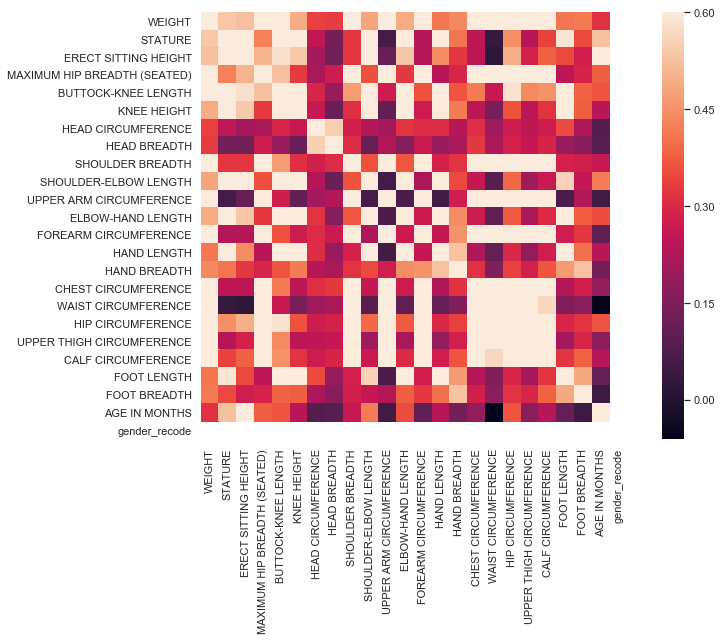

In [8]:
# Make the correlation matrix.
# Worth ordering the heatmap.
corrmat = df_women.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.6, square=True)
plt.tight_layout()
plt.savefig('CorrMat on Women.png', dpi=300)
plt.show()

In [9]:
# PCA from 127 features to 2
from sklearn.decomposition import PCA
from sklearn import preprocessing
#X_scaled = pd.DataFrame
X_women = df_women.loc[:, (df_women.columns != 'CHEST CIRCUMFERENCE') & (df_women.columns != 'cat_size')]

#I need a different method

X_women_scaled = pd.DataFrame(preprocessing.scale(X_women), index=X_women.index, columns=X_women.columns)
#scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

pca = PCA(n_components=10)
pc_women = pca.fit_transform(X_women_scaled)
principalDf = pd.DataFrame(data = pc_women)

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':


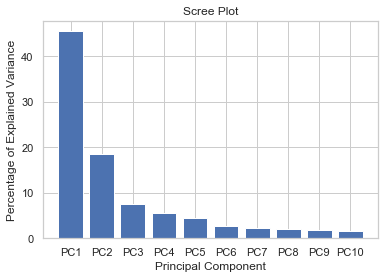

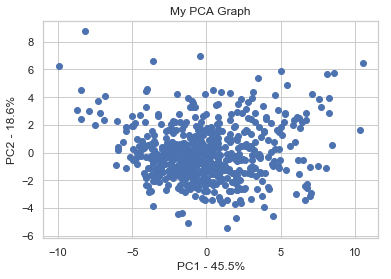

In [10]:
#The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.savefig('Scree_Plot_women.png', dpi=300)
plt.show()
 
#the following code makes a fancy looking plot using PC
pca_df = pd.DataFrame(pc_women, columns=labels)
 
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
plt.savefig('PCA Scatter Women.png', dpi=300) 
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.001s...
[t-SNE] Computed neighbors for 576 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.722834
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.931278
[t-SNE] KL divergence after 300 iterations: 0.386779


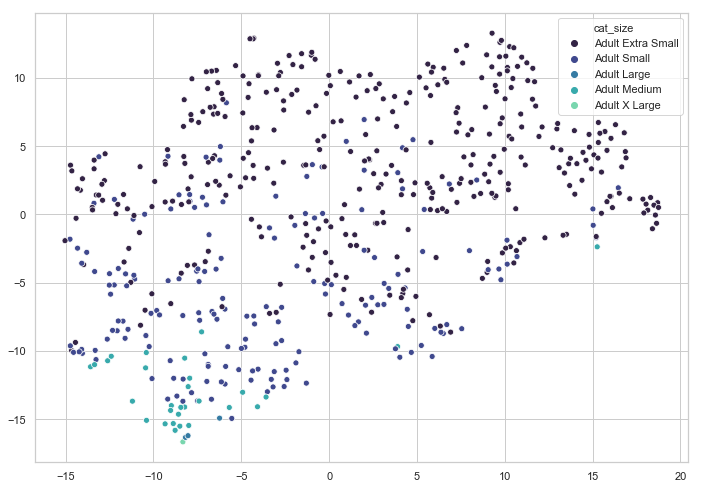

In [12]:
# This shows the clustering of datapoints and their relative shirt size.
import time
from sklearn import cluster
from sklearn.manifold import TSNE
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

n_sne = 7000

time_start = time.time() 
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300) 
tsne_results_women = tsne.fit_transform(pc_women[:,0:2])

#sns.scatterplot(tsne_results[:,0], tsne_results[:,1],
 #              data=X_scaled, hue='WEIGHT', palette='mako')

sns.scatterplot(tsne_results_women[:,0], tsne_results_women[:,1],
                hue=df_women.cat_size, palette='mako', ax=ax)
plt.savefig('TSNE Women.png', dpi=300) 

## Since there is strong correlation in this dataset we will use some linear modeling methods that handle correlated features.

In [13]:
#Defining X and y
X = pc_women[:, 0:2]
y = df_women['CHEST CIRCUMFERENCE']

# Creating my training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


Coefficients: 
 [10.79091952 10.55230825]

Intercept: 
 822.1463645622229

Mean (SD) Cross Validation Score: 0.73 (+/- 0.18)

Cross Validation Scores:
[0.76753485 0.72557773 0.89267645 0.68312065 0.63462836 0.77076123
 0.72542065 0.66201953 0.60382598 0.85563492]


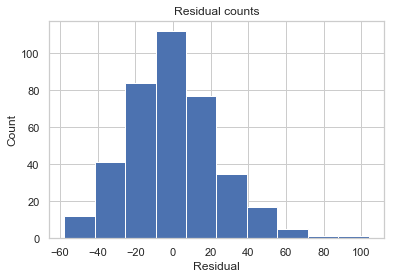

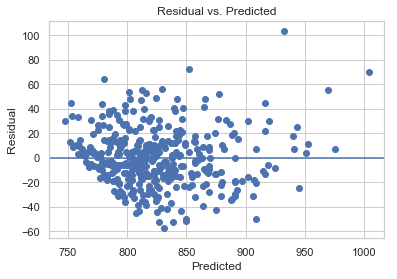

In [14]:
# Linear Regression on PCA
from sklearn import linear_model

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)

# Cross validation
score = cross_val_score(regr, X_train, y_train, cv=10)

print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nCross Validation Scores:')
print(score)

# Extract predicted values.
predicted = regr.predict(X_train).ravel()
actual = y_train

# Calculate the error, also called the residual.
residual = actual - predicted

# Plot Residual counts
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.savefig('Residual Counts PCA OLS Women.png', dpi=300) 
plt.show()

# Plot residual v predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.savefig('Scedacity PCA OLS Women.png', dpi=300) 
plt.show()

### OLS is not performing well, even after a PCA transformation.


### I am going to see if performance improves with more advanced linear regression via Ridge and Lasso.

### First I'll do some feature selection. 

In [15]:
# Feature selection with variance threshold
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
variance_threshold = sel.fit_transform(X_women_scaled)
variance_threshold

array([[-0.56973361, -0.32817015, -0.07923014, ...,  1.02316931,
         1.88113801, -0.58614483],
       [ 0.17472298,  0.194362  , -0.36050325, ...,  0.45391049,
         1.14366277, -0.46945609],
       [-1.50345884, -1.42548767, -1.41527739, ..., -0.44063908,
         0.40618753, -1.40296602],
       ...,
       [-1.42775139, -0.01465086, -0.85273118, ...,  0.86052393,
        -0.70002532,  0.65853507],
       [-1.22586485, -0.92908212, -1.06368601, ...,  0.69787855,
        -0.70002532, -1.13069229],
       [-0.65805897,  0.01147575,  0.7880286 , ..., -0.03402564,
        -0.3312877 ,  0.69743132]])

In [16]:
# Creating my training data
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    variance_threshold, y, test_size=0.33, random_state=42)


R-squared:
0.8438549495086503

Mean (SD) Cross Validation Score: 0.80 (+/- 0.11)

Cross Validation Scores:
[0.76358587 0.83659629 0.86882159 0.80831256 0.70545042 0.86636519
 0.83599037 0.75368662 0.73950212 0.86586275]


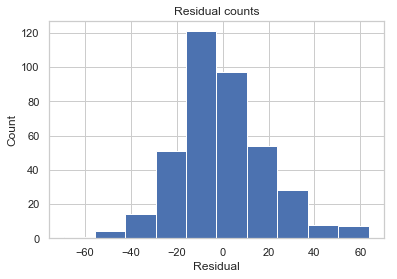

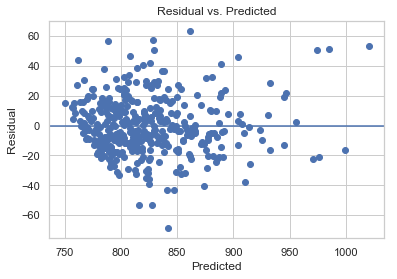

In [17]:
# OLS Regression with Variance Threshold
regr1 = linear_model.LinearRegression()
regr1.fit(X_train1, y_train1)
print('\nR-squared:')
print(regr1.score(X_train1, y_train1))

# Cross validation

score = cross_val_score(regr1, X_train1, y_train1, cv=10)

print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nCross Validation Scores:')
print(score)

# Extract predicted values.
predicted = regr1.predict(X_train1).ravel()
actual = y_train1

# Calculate the error, also called the residual.
residual = actual - predicted

# Plot Residual counts
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.savefig('Residual Counts OLS2 Women.png', dpi=300) 
plt.show()

# Plot residual v predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.savefig('Scedacity OLS2 Women.png', dpi=300) 
plt.show()

## Still not the greatest. Let's compare Lasso and Ridge.

In [18]:
# Creating my training data
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_women_scaled, y, test_size=0.33, random_state=42)

R² for the Lasso model:
0.8360895973926742

Mean (SD) Cross Validation Score: 0.80 (+/- 0.12)

Cross Validation Scores:
[0.75937629 0.82877168 0.89429176 0.81389763 0.69722745 0.85702925
 0.81401313 0.73029802 0.74595307 0.86970301]


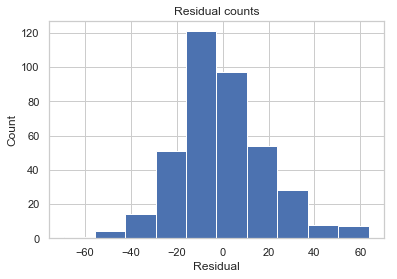

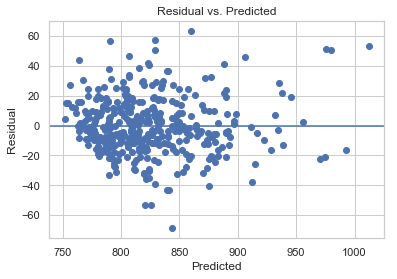

In [19]:
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train2, y_train2)
print('R² for the Lasso model:')
print(lass.score(X_train2, y_train2))

# Cross validation

score = cross_val_score(lassfit, X_train2, y_train2, cv=10)

print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nCross Validation Scores:')
print(score)

# Extract predicted values.
predicted = lass.predict(X_train2).ravel()
actual = y_train2

# Plot Residual distribution
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.savefig('Residual Counts Lasso Women.png', dpi=300) 
plt.show()

# Plot Residual vs. Predicted 
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.savefig('Scedacity Lasso Women.png', dpi=300) 
plt.show()


R-squared:
-280.60586058185606

Mean (SD) Cross Validation Score: -343.93 (+/- 215.67)

Cross Validation Scores:
[-262.71601073 -410.1102316  -254.105075   -355.61045947 -581.78626496
 -180.96891222 -361.79581642 -359.49982709 -417.9150775  -254.83575378]


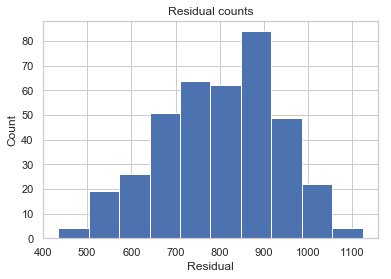

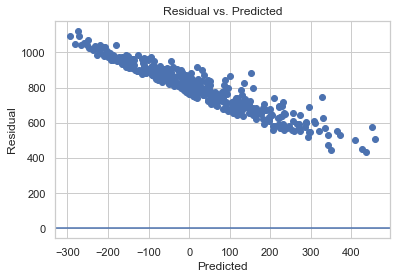

In [23]:
#Ridge Regression
ridgeregr = linear_model.Ridge(alpha=1, fit_intercept=False) 
ridgeregr.fit(X_train2, y_train2)
print('\nR-squared:')
print(ridgeregr.score(X_train2, y_train2))

# Cross validation

score = cross_val_score(ridgeregr, X_train2, y_train2, cv=10)

print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nCross Validation Scores:')
print(score)

# Extract predicted values.
predicted = ridgeregr.predict(X_train2).ravel()
actual = y_train2

# Calculate the error, also called the residual.
residual = actual - predicted

# Plot Residual distribution
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.savefig('Residual Counts Ridge Women.png', dpi=300) 
plt.show()

# Plot Residual vs. Predicted 
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.savefig('Scedacity Ridge Women.png', dpi=300) 
plt.show()